# Clustering for dataset exploration

In this notebook we will discover the underlying groups (or "clusters") in a dataset. We will be clustering companies using their stock market prices, and distinguishing different species by clustering their measurements.

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.utils import Bunch

import matplotlib.pyplot as plt
from typing import NewType
import pandas as pd
import numpy as np
import seaborn as sns
import os

%matplotlib inline

In [2]:
DataFrame = NewType('DataFrame', pd.DataFrame)
NumpyArray = NewType('NumpyArray', np.ndarray)
Series = NewType('Series', pd.Series)

basedir: str = os.getcwd()

## Section 1. K-means clustering

In this section, we will cluster our samples using k-means clustering. This model finds a specified number of clusters in the samples.

### Subsection 1.1.1: Iris

First, we load the Iris dataset:

In [3]:
iris: Bunch = load_iris()
iris_features: DataFrame = pd.DataFrame(data=iris['data'], columns=iris.feature_names)
iris_features.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [4]:
X: NumpyArray = iris.data
y: NumpyArray = iris.target

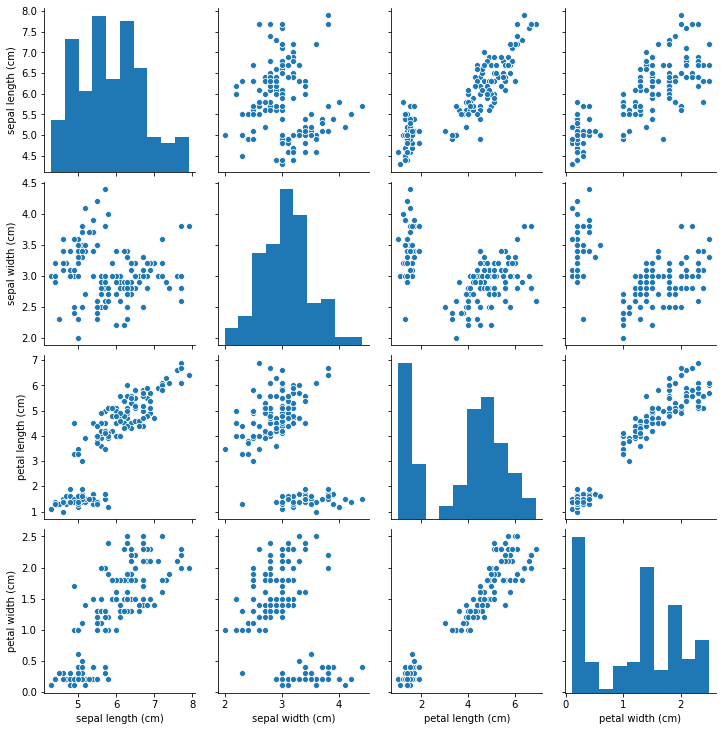

In [5]:
sns.pairplot(iris_features)
plt.show()

Let's specify 3 clusters as there are 3 species of iris. Let's fit the model to the data.

In [6]:
samples: NumpyArray = iris.data[:-10]
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(samples)

KMeans(n_clusters=3)

The fitting is done by locating and memorizing the regions where the different clusters are located.

We can now use the `.predict()` method. This returns a cluster label for each sample, indicating to which cluster a sample belongs.

In [7]:
labels = kmeans_model.predict(samples)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2])

k-means remembers the mean of each cluster. These are called the "_centroids_". Therefore, new samples are assigned to the cluster whose centroid is the closest.

In [8]:
new_samples: NumpyArray = iris.data[-10:]
new_labels = kmeans_model.predict(new_samples)
new_labels

array([2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [26]:
sepal_petal_len: DataFrame = iris_features.iloc[:-10, :].filter(regex='length', axis=1)
sepal_petal_len.head(3)

,sepal length (cm),petal length (cm)
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3


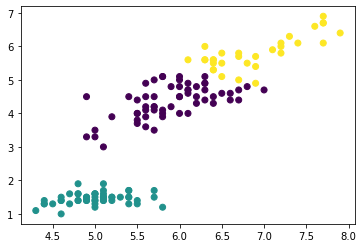

In [27]:
sepal_len: Series = sepal_petal_len.filter(regex='sepal', axis=1)
petal_len: Series = sepal_petal_len.filter(regex='petal', axis=1)

plt.scatter(sepal_len, petal_len, c=labels)
plt.show()

In [31]:
centroids_iris: DataFrame = pd.DataFrame(data=kmeans_model.cluster_centers_, columns=iris.feature_names)
centroids_iris.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.896610,2.749153,4.359322,1.411864
1,5.006000,3.428000,1.462000,0.246000
2,6.896774,3.054839,5.809677,2.019355


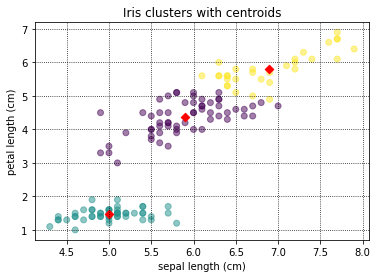

In [40]:
sepal_petal_len_centroids: DataFrame = centroids_iris.filter(regex='length', axis=1)
sepal_len_centroids = sepal_petal_len_centroids.filter(regex='sepal', axis=1)
petal_len_centroids = sepal_petal_len_centroids.filter(regex='petal', axis=1)

plt.scatter(sepal_len, petal_len, c=labels, alpha=0.5)
plt.scatter(sepal_len_centroids, petal_len_centroids, c='r', marker='D')
plt.title('Iris clusters with centroids')
plt.xlabel(sepal_len.columns[0])
plt.ylabel(petal_len.columns[0])
plt.grid(True, c='k', ls=':')
plt.show()

### Subsection 1.1.2 Points

In [43]:
def load_txt(filename: str, basedir: str):
    path: str = os.path.normpath(os.path.join(basedir, filename))
    with open(filename, mode='r') as f:
        for i, line in enumerate(f.readlines()):
            if i == 0:
                data: NumpyArray = np.array(list(map(float, line.strip('\n').split(', '))))
            else:
                row = np.array(list(map(float, line.strip('\n').split(', '))))
                data = np.vstack((points, row))
    return data

In [47]:
points: NumpyArray = load_txt('data/points.txt', basedir)
new_points: NumpyArray = load_txt('data/new_points.txt', basedir)
print(points.shape)

(302, 2)


We are given an array `points` of size 300x2, where each row gives the (x, y) coordinates of a point on a map. We will first make a scatter plot of these points, and use the scatter plot to guess how many clusters there are.

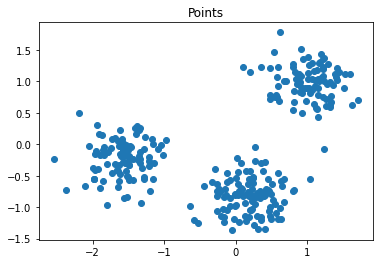

In [50]:
xs: NumpyArray = points[:, 0]
ys: NumpyArray = points[:, 1]
plt.scatter(xs, ys)
plt.title('Points')
plt.show()

The scatter plot suggests that there are 3 distinct clusters. We will now create a KMeans model to find 3 clusters, and fit it to the data points. After the model has been fit, we will obtain the cluster labels for some *new points* using the `.predict()` method.

In [51]:
model = KMeans(n_clusters=3)
model.fit(points)
labels = model.predict(new_points)
labels

array([2, 0, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2,
       0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0,
       0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 1, 1, 0,
       1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 0, 2,
       2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0,
       2, 0, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1,
       0, 2, 0, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0,
       1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0,
       2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 0, 2, 1, 0, 1, 2, 1, 0, 2, 0,
       0, 0, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 0,
       2, 2, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 1, 1,
       1, 1, 2, 2, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 0, 2,
       1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0,

We have successfully performed k-Means clustering and predicted the labels of new points. But it is not easy to inspect the clustering by just looking at the printed labels. A visualization would be far more useful.  Below, we will inspect our clustering with a scatter plot!

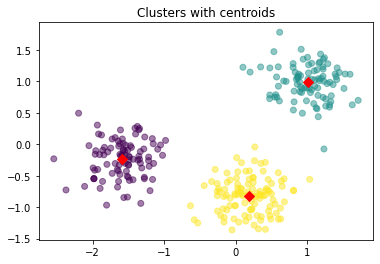

In [62]:
xs: NumpyArray = new_points[:, 0]
ys: NumpyArray = new_points[:, 1]

plt.scatter(xs, ys, c=labels, alpha=0.5)

centroids = model.cluster_centers_

centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]

plt.scatter(centroids_x, centroids_y, marker='D', s=50, c='r')
plt.title('Clusters with centroids')
plt.show()

## Section 2. Evaluating a clustering

We have seen how to use k-means to cluster the iris samples into three clusters. But how can we evaluate the quality of this clustering?